# Notebook 6: Resume Scoring System

## Objective
Implement a comprehensive, rule-based resume scoring system (0-100) with multiple weighted factors.

## Goals
1. Implement completeness scoring (resume sections present)
2. Implement skills matching scoring (with/without job description)
3. Calculate experience relevance and duration score
4. Score education level and quality
5. Assess certifications and professional development
6. Calculate ATS-friendliness and formatting quality
7. Combine into overall weighted score (0-100)

## Scoring Components (Total: 100 points)

| Component | Weight | Description |
|-----------|--------|-------------|
| **Completeness** | 20 pts | Resume sections present (Experience, Education, Skills, etc.) |
| **Skills Match** | 25 pts | Technical skills vs job description match |
| **Experience** | 20 pts | Years of experience + relevance |
| **Education** | 15 pts | Degree level (HS, BS, MS, PhD) |
| **Certifications** | 10 pts | Professional certifications and licenses |
| **Format Quality** | 10 pts | ATS-friendly, proper structure |

## Dependencies
- Results from Notebooks 3 (preprocessing) and 4 (entity extraction)


---


## 1. Setup and Imports


In [1]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions from previous notebooks (simulated here)
# In production, these would come from utils/ and models/

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")
print("\nScoring System Ready:")


✓ All imports successful

Scoring System Ready:


---


## 2. Component 1: Completeness Score (20 points)

Scores based on presence of essential resume sections.


In [2]:
def score_completeness(text: str) -> dict:
    """
    Score resume completeness based on essential sections.
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with score and details
    """
    # Define essential sections with their importance weights
    sections = {
        'experience': {'pattern': r'\b(experience|employment|work history)\b', 'points': 6, 'required': True},
        'education': {'pattern': r'\b(education|academic|qualifications)\b', 'points': 5, 'required': True},
        'skills': {'pattern': r'\b(skills|technical skills|competencies)\b', 'points': 4, 'required': True},
        'summary': {'pattern': r'\b(summary|profile|objective)\b', 'points': 2, 'required': False},
        'certifications': {'pattern': r'\b(certifications|certificates|licenses)\b', 'points': 2, 'required': False},
        'projects': {'pattern': r'\b(projects|portfolio)\b', 'points': 1, 'required': False},
    }
    
    max_score = 20
    earned_score = 0
    found_sections = []
    missing_required = []
    
    for section_name, section_info in sections.items():
        if re.search(section_info['pattern'], text, re.IGNORECASE):
            earned_score += section_info['points']
            found_sections.append(section_name)
        elif section_info['required']:
            missing_required.append(section_name)
    
    return {
        'score': earned_score,
        'max_score': max_score,
        'percentage': (earned_score / max_score) * 100,
        'found_sections': found_sections,
        'missing_required': missing_required,
        'section_count': len(found_sections)
    }


# Test the function
test_resume = """
John Doe

PROFESSIONAL SUMMARY
Experienced software engineer with 5+ years.

EXPERIENCE
Senior Developer at Tech Corp (2020-Present)

EDUCATION
BS Computer Science, MIT

SKILLS
Python, Java, React, AWS
"""

result = score_completeness(test_resume)

print("Completeness Scoring Test")
print("="*60)
print(f"Score: {result['score']}/{result['max_score']} ({result['percentage']:.1f}%)")
print(f"Sections found: {result['found_sections']}")
print(f"Missing required: {result['missing_required']}")
print("\n✓ Completeness scoring function defined")


Completeness Scoring Test
Score: 17/20 (85.0%)
Sections found: ['experience', 'education', 'skills', 'summary']
Missing required: []

✓ Completeness scoring function defined


---


## 3. Component 2: Skills Match Score (25 points)

Scores based on technical skills, with optional job description matching.


In [3]:
# Define comprehensive skill sets
SKILL_CATEGORIES = {
    'programming_languages': [
        'Python', 'Java', 'JavaScript', 'TypeScript', 'C++', 'C#', 'Ruby', 'Go', 
        'Rust', 'Swift', 'Kotlin', 'PHP', 'Scala', 'R', 'MATLAB', 'Perl'
    ],
    'web_frameworks': [
        'React', 'Angular', 'Vue.js', 'Vue', 'Node.js', 'Django', 'Flask', 
        'FastAPI', 'Spring', 'Spring Boot', 'Express', 'ASP.NET', 'Laravel'
    ],
    'databases': [
        'SQL', 'MySQL', 'PostgreSQL', 'MongoDB', 'Redis', 'Elasticsearch',
        'Oracle', 'SQLite', 'Cassandra', 'DynamoDB', 'Neo4j', 'Firebase'
    ],
    'cloud_devops': [
        'AWS', 'Azure', 'GCP', 'Google Cloud', 'Docker', 'Kubernetes', 'K8s',
        'Jenkins', 'CI/CD', 'Terraform', 'Ansible', 'Linux', 'Unix', 'Git'
    ],
    'data_ml': [
        'Machine Learning', 'Deep Learning', 'TensorFlow', 'PyTorch', 'Keras',
        'Scikit-learn', 'Pandas', 'NumPy', 'NLP', 'Computer Vision', 'AI'
    ],
    'other': [
        'Agile', 'Scrum', 'REST API', 'GraphQL', 'Microservices', 'Testing',
        'Selenium', 'Jira', 'Confluence', 'OOP', 'Design Patterns'
    ]
}

# Flatten all skills
ALL_SKILLS = []
for category_skills in SKILL_CATEGORIES.values():
    ALL_SKILLS.extend(category_skills)

print(f"✓ Loaded {len(ALL_SKILLS)} technical skills across {len(SKILL_CATEGORIES)} categories")


✓ Loaded 77 technical skills across 6 categories


In [4]:
def extract_skills_simple(text: str) -> list:
    """Extract skills from text using pattern matching."""
    found_skills = []
    text_lower = text.lower()
    
    for skill in ALL_SKILLS:
        # Case-insensitive whole word match
        if re.search(r'\b' + re.escape(skill.lower()) + r'\b', text_lower):
            found_skills.append(skill)
    
    return list(set(found_skills))


def score_skills(resume_text: str, job_description: str = None) -> dict:
    """
    Score resume based on skills.
    
    Args:
        resume_text: Resume text
        job_description: Optional job description for matching
    
    Returns:
        Dictionary with score and details
    """
    max_score = 25
    resume_skills = extract_skills_simple(resume_text)
    
    result = {
        'resume_skills': resume_skills,
        'resume_skill_count': len(resume_skills),
    }
    
    # Base score: skill diversity (0-10 points)
    skill_diversity_score = min(10, len(resume_skills) * 0.5)  # 0.5 points per skill, max 10
    
    # Job matching score (0-15 points) if job description provided
    if job_description:
        job_skills = extract_skills_simple(job_description)
        matching_skills = set(resume_skills) & set(job_skills)
        
        if len(job_skills) > 0:
            match_percentage = len(matching_skills) / len(job_skills)
            job_match_score = match_percentage * 15
        else:
            job_match_score = 0
        
        result['job_skills'] = job_skills
        result['job_skill_count'] = len(job_skills)
        result['matching_skills'] = list(matching_skills)
        result['matching_count'] = len(matching_skills)
        result['match_percentage'] = match_percentage * 100 if len(job_skills) > 0 else 0
        result['job_match_score'] = job_match_score
    else:
        # No job description: use full 15 points for skill diversity
        job_match_score = min(15, len(resume_skills) * 0.75)
        result['job_match_score'] = job_match_score
    
    total_score = skill_diversity_score + job_match_score
    
    result['skill_diversity_score'] = skill_diversity_score
    result['score'] = total_score
    result['max_score'] = max_score
    result['percentage'] = (total_score / max_score) * 100
    
    return result


# Test without job description
test_resume_skills = """
SKILLS
Python, Java, JavaScript, React, Django, PostgreSQL, AWS, Docker, Git
Machine Learning, TensorFlow
"""

result1 = score_skills(test_resume_skills)

print("Skills Scoring Test (No Job Description)")
print("="*60)
print(f"Skills found: {result1['resume_skill_count']}")
print(f"Skills: {result1['resume_skills'][:5]}...")
print(f"Score: {result1['score']:.1f}/{result1['max_score']} ({result1['percentage']:.1f}%)")
print(f"  Diversity score: {result1['skill_diversity_score']:.1f}/10")
print(f"  Job match score: {result1['job_match_score']:.1f}/15")


Skills Scoring Test (No Job Description)
Skills found: 11
Skills: ['Django', 'TensorFlow', 'Java', 'Machine Learning', 'React']...
Score: 13.8/25 (55.0%)
  Diversity score: 5.5/10
  Job match score: 8.2/15


In [5]:
# Test WITH job description
job_desc = """
We are looking for a Senior Software Engineer with:
- Strong Python and JavaScript experience
- Experience with React and Django
- Cloud experience (AWS or Azure)
- Docker and Kubernetes knowledge
- Machine Learning background preferred
"""

result2 = score_skills(test_resume_skills, job_desc)

print("\n\nSkills Scoring Test (With Job Description)")
print("="*60)
print(f"Resume skills: {result2['resume_skill_count']}")
print(f"Job required skills: {result2['job_skill_count']}")
print(f"Matching skills: {result2['matching_count']} ({result2['match_percentage']:.1f}%)")
print(f"  Matched: {result2['matching_skills']}")
print(f"\nScore: {result2['score']:.1f}/{result2['max_score']} ({result2['percentage']:.1f}%)")
print(f"  Diversity score: {result2['skill_diversity_score']:.1f}/10")
print(f"  Job match score: {result2['job_match_score']:.1f}/15")
print("\n✓ Skills scoring function defined")




Skills Scoring Test (With Job Description)
Resume skills: 11
Job required skills: 9
Matching skills: 7 (77.8%)
  Matched: ['Django', 'Machine Learning', 'React', 'Docker', 'Python', 'JavaScript', 'AWS']

Score: 17.2/25 (68.7%)
  Diversity score: 5.5/10
  Job match score: 11.7/15

✓ Skills scoring function defined


---


## 4. Component 3: Experience Score (20 points)

Scores based on years of experience and relevance.


In [6]:
def extract_years_of_experience(text: str) -> int:
    """
    Extract years of experience from resume text.
    
    Args:
        text: Resume text
    
    Returns:
        Estimated years of experience
    """
    # Patterns to find experience mentions
    patterns = [
        r'(\d+)\+?\s*years?\s*(?:of)?\s*experience',
        r'experience.*?(\d+)\+?\s*years?',
        r'(\d+)\+?\s*yrs?\s*(?:of)?\s*experience',
    ]
    
    years_found = []
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        years_found.extend([int(y) for y in matches])
    
    # Also estimate from date ranges (2020-2023 = 3 years)
    date_ranges = re.findall(r'(\d{4})\s*[-–—]\s*(\d{4}|present|current)', text, re.IGNORECASE)
    for start, end in date_ranges:
        if end.lower() in ['present', 'current']:
            end = 2024  # Current year
        else:
            end = int(end)
        years = int(end) - int(start)
        if 0 < years <= 50:  # Sanity check
            years_found.append(years)
    
    # Return the maximum found (most conservative estimate)
    return max(years_found) if years_found else 0


def score_experience(text: str) -> dict:
    """
    Score experience based on years and quality indicators.
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with score and details
    """
    max_score = 20
    years = extract_years_of_experience(text)
    
    # Years score (0-15 points)
    # 0-1 years: 3 points
    # 2-3 years: 7 points
    # 4-5 years: 10 points
    # 6-8 years: 13 points
    # 9+ years: 15 points
    if years == 0:
        years_score = 0
    elif years <= 1:
        years_score = 3
    elif years <= 3:
        years_score = 7
    elif years <= 5:
        years_score = 10
    elif years <= 8:
        years_score = 13
    else:
        years_score = 15
    
    # Quality indicators (0-5 points)
    quality_score = 0
    quality_indicators = []
    
    # Leadership indicators
    if re.search(r'\b(led|managed|supervised|mentored)\b', text, re.IGNORECASE):
        quality_score += 1.5
        quality_indicators.append('Leadership')
    
    # Senior level
    if re.search(r'\b(senior|lead|principal|architect|director)\b', text, re.IGNORECASE):
        quality_score += 1.5
        quality_indicators.append('Senior Level')
    
    # Achievements/metrics
    if re.search(r'(\d+%|increased|improved|reduced|saved|\$\d+)', text, re.IGNORECASE):
        quality_score += 1
        quality_indicators.append('Quantified Achievements')
    
    # Multiple positions
    position_count = len(re.findall(r'\b\d{4}\s*[-–—]\s*(?:\d{4}|present)', text, re.IGNORECASE))
    if position_count >= 2:
        quality_score += 1
        quality_indicators.append('Multiple Positions')
    
    total_score = years_score + quality_score
    
    return {
        'years': years,
        'years_score': years_score,
        'quality_score': quality_score,
        'quality_indicators': quality_indicators,
        'score': total_score,
        'max_score': max_score,
        'percentage': (total_score / max_score) * 100
    }


# Test the function
test_experience = """
PROFESSIONAL EXPERIENCE

Senior Software Engineer | Google LLC | 2018-Present (5+ years)
- Led team of 8 engineers developing cloud infrastructure
- Increased system performance by 45%
- Managed $2M budget

Software Engineer | Microsoft | 2015-2018
- Developed Python applications
"""

result = score_experience(test_experience)

print("\nExperience Scoring Test")
print("="*60)
print(f"Years detected: {result['years']}")
print(f"Quality indicators: {result['quality_indicators']}")
print(f"Score: {result['score']:.1f}/{result['max_score']} ({result['percentage']:.1f}%)")
print(f"  Years score: {result['years_score']}/15")
print(f"  Quality score: {result['quality_score']}/5")
print("\n✓ Experience scoring function defined")



Experience Scoring Test
Years detected: 6
Quality indicators: ['Leadership', 'Senior Level', 'Quantified Achievements', 'Multiple Positions']
Score: 18.0/20 (90.0%)
  Years score: 13/15
  Quality score: 5.0/5

✓ Experience scoring function defined


---


## 5. Component 4: Education Score (15 points)

Scores based on degree level and institution prestige.


In [7]:
def score_education(text: str) -> dict:
    """
    Score education based on degree level and institution.
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with score and details
    """
    max_score = 15
    
    # Degree levels and their scores
    degree_scores = {
        'PhD': 15,
        'Doctorate': 15,
        'Doctor of Philosophy': 15,
        'Ph.D.': 15,
        'Masters': 12,
        'Master': 12,
        'M.S.': 12,
        'M.A.': 12,
        'MBA': 12,
        'M.S': 12,
        'Bachelors': 9,
        'Bachelor': 9,
        'B.S.': 9,
        'B.A.': 9,
        'B.S': 9,
        'Associates': 6,
        'Associate': 6,
        'A.S.': 6,
        'High School': 3,
        'Diploma': 3,
    }
    
    # Find highest degree
    highest_score = 0
    highest_degree = None
    found_degrees = []
    
    for degree, score in degree_scores.items():
        if re.search(r'\b' + re.escape(degree) + r'\b', text, re.IGNORECASE):
            found_degrees.append(degree)
            if score > highest_score:
                highest_score = score
                highest_degree = degree
    
    # Bonus points for prestigious institutions
    top_institutions = [
        'MIT', 'Stanford', 'Harvard', 'Berkeley', 'Cambridge', 'Oxford',
        'Caltech', 'Princeton', 'Yale', 'Columbia', 'Carnegie Mellon', 'CMU'
    ]
    
    prestige_bonus = 0
    found_institutions = []
    for institution in top_institutions:
        if re.search(r'\b' + institution + r'\b', text, re.IGNORECASE):
            prestige_bonus = min(3, prestige_bonus + 1.5)  # Max 3 bonus points
            found_institutions.append(institution)
            break  # Only count once
    
    total_score = min(max_score, highest_score + prestige_bonus)
    
    return {
        'highest_degree': highest_degree,
        'highest_degree_score': highest_score,
        'found_degrees': found_degrees,
        'prestigious_institution': len(found_institutions) > 0,
        'institutions_found': found_institutions,
        'prestige_bonus': prestige_bonus,
        'score': total_score,
        'max_score': max_score,
        'percentage': (total_score / max_score) * 100
    }


# Test the function
test_education = """
EDUCATION

Ph.D. in Computer Science | Stanford University | 2020
Master of Science in Data Science | MIT | 2018
Bachelor of Science in Computer Engineering | UC Berkeley | 2016
"""

result = score_education(test_education)

print("\nEducation Scoring Test")
print("="*60)
print(f"Highest degree: {result['highest_degree']}")
print(f"All degrees: {result['found_degrees']}")
print(f"Prestigious institution: {result['prestigious_institution']}")
if result['institutions_found']:
    print(f"  Institutions: {result['institutions_found']}")
print(f"\nScore: {result['score']:.1f}/{result['max_score']} ({result['percentage']:.1f}%)")
print(f"  Degree score: {result['highest_degree_score']}/15")
print(f"  Prestige bonus: +{result['prestige_bonus']:.1f}")
print("\n✓ Education scoring function defined")



Education Scoring Test
Highest degree: Master
All degrees: ['Master', 'Bachelor']
Prestigious institution: True
  Institutions: ['MIT']

Score: 13.5/15 (90.0%)
  Degree score: 12/15
  Prestige bonus: +1.5

✓ Education scoring function defined


---


## 6. Component 5: Certifications Score (10 points)

Scores based on professional certifications and licenses.


In [8]:
def score_certifications(text: str) -> dict:
    """
    Score professional certifications.
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with score and details
    """
    max_score = 10
    
    # Define certification categories and their values
    certifications = {
        # Cloud Certifications (2 points each)
        'AWS Certified': 2,
        'AWS Solutions Architect': 2,
        'AWS Developer': 2,
        'Azure': 2,
        'Google Cloud': 2,
        'GCP': 2,
        
        # Project Management (2 points each)
        'PMP': 2,
        'Certified Scrum Master': 2,
        'CSM': 2,
        'Agile Certified': 2,
        
        # Security (2 points each)
        'CISSP': 2,
        'CompTIA Security': 2,
        'CEH': 2,
        
        # Technical (1.5 points each)
        'CompTIA': 1.5,
        'Cisco': 1.5,
        'CCNA': 1.5,
        'Oracle Certified': 1.5,
        
        # Professional (1 point each)
        'Professional Engineer': 1,
        'PE': 1,
        'Six Sigma': 1,
    }
    
    found_certs = []
    total_score = 0
    
    for cert_name, points in certifications.items():
        if re.search(r'\b' + re.escape(cert_name) + r'\b', text, re.IGNORECASE):
            found_certs.append(cert_name)
            total_score += points
    
    # Cap at max score
    total_score = min(max_score, total_score)
    
    # Bonus for having certifications section
    has_cert_section = bool(re.search(r'\b(certifications|certificates|licenses)\b', text, re.IGNORECASE))
    
    return {
        'found_certifications': found_certs,
        'certification_count': len(found_certs),
        'has_cert_section': has_cert_section,
        'score': total_score,
        'max_score': max_score,
        'percentage': (total_score / max_score) * 100
    }


# Test the function
test_certs = """
CERTIFICATIONS
- AWS Certified Solutions Architect - Professional
- Certified Scrum Master (CSM)
- PMP (Project Management Professional)
- Google Cloud Professional Data Engineer
"""

result = score_certifications(test_certs)

print("\nCertification Scoring Test")
print("="*60)
print(f"Certifications found: {result['certification_count']}")
print(f"  {result['found_certifications']}")
print(f"Has certification section: {result['has_cert_section']}")
print(f"\nScore: {result['score']:.1f}/{result['max_score']} ({result['percentage']:.1f}%)")
print("\n✓ Certification scoring function defined")



Certification Scoring Test
Certifications found: 5
  ['AWS Certified', 'Google Cloud', 'PMP', 'Certified Scrum Master', 'CSM']
Has certification section: True

Score: 10.0/10 (100.0%)

✓ Certification scoring function defined


---


## 7. Component 6: Format Quality Score (10 points)

Scores based on ATS-friendliness and formatting quality.


In [9]:
def score_format_quality(text: str) -> dict:
    """
    Score resume formatting and ATS-friendliness.
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with score and details
    """
    max_score = 10
    score = 0
    issues = []
    good_practices = []
    
    # Good: Appropriate length (500-2000 words)
    word_count = len(text.split())
    if 500 <= word_count <= 2000:
        score += 2
        good_practices.append(f'Appropriate length ({word_count} words)')
    elif word_count < 500:
        issues.append(f'Too short ({word_count} words)')
    else:
        issues.append(f'Too long ({word_count} words)')
    
    # Good: Has contact information
    has_email = bool(re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text))
    has_phone = bool(re.search(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', text))
    
    if has_email:
        score += 2
        good_practices.append('Has email')
    else:
        issues.append('Missing email')
    
    if has_phone:
        score += 1
        good_practices.append('Has phone')
    
    # Good: Clear section headers
    section_count = len(re.findall(r'^[A-Z\s]{3,}:?\s*$', text, re.MULTILINE))
    if section_count >= 3:
        score += 2
        good_practices.append(f'Clear section headers ({section_count})')
    else:
        issues.append('Weak section headers')
    
    # Bad: Excessive special characters (not ATS-friendly)
    special_char_ratio = len(re.findall(r'[^\w\s.,;:()\-]', text)) / max(len(text), 1)
    if special_char_ratio < 0.05:
        score += 1
        good_practices.append('ATS-friendly (minimal special chars)')
    else:
        issues.append('Too many special characters')
    
    # Good: Bullet points for readability
    has_bullets = bool(re.search(r'[•\-*]\s', text))
    if has_bullets:
        score += 1
        good_practices.append('Uses bullet points')
    
    # Good: Consistent formatting
    if section_count >= 3 and has_bullets:
        score += 1
        good_practices.append('Consistent formatting')
    
    return {
        'score': score,
        'max_score': max_score,
        'percentage': (score / max_score) * 100,
        'word_count': word_count,
        'has_email': has_email,
        'has_phone': has_phone,
        'good_practices': good_practices,
        'issues': issues
    }


# Test the function
test_format = """
JOHN DOE
Email: john.doe@email.com | Phone: (123) 456-7890

PROFESSIONAL SUMMARY
Experienced software engineer with expertise in Python and cloud technologies.

EXPERIENCE
• Senior Software Engineer at Tech Corp (2020-Present)
• Software Developer at StartUp Inc (2018-2020)

EDUCATION
• M.S. Computer Science, Stanford University
• B.S. Engineering, MIT

SKILLS
• Programming: Python, Java, JavaScript
• Cloud: AWS, Docker, Kubernetes
"""

result = score_format_quality(test_format)

print("\nFormat Quality Scoring Test")
print("="*60)
print(f"Word count: {result['word_count']}")
print(f"Good practices: {result['good_practices']}")
print(f"Issues: {result['issues']}")
print(f"\nScore: {result['score']}/{result['max_score']} ({result['percentage']:.1f}%)")
print("\n✓ Format quality scoring function defined")



Format Quality Scoring Test
Word count: 58
Good practices: ['Has email', 'Has phone', 'Clear section headers (5)', 'ATS-friendly (minimal special chars)', 'Uses bullet points', 'Consistent formatting']
Issues: ['Too short (58 words)']

Score: 8/10 (80.0%)

✓ Format quality scoring function defined


---


## 8. Complete Resume Scoring Function

Combine all components into a comprehensive scoring system.


In [10]:
def calculate_resume_score(resume_text: str, job_description: str = None) -> dict:
    """
    Calculate comprehensive resume score across all components.
    
    Args:
        resume_text: Resume text
        job_description: Optional job description for skills matching
    
    Returns:
        Dictionary with overall score and component breakdowns
    """
    # Calculate all component scores
    completeness = score_completeness(resume_text)
    skills = score_skills(resume_text, job_description)
    experience = score_experience(resume_text)
    education = score_education(resume_text)
    certifications = score_certifications(resume_text)
    format_quality = score_format_quality(resume_text)
    
    # Calculate total score (out of 100)
    total_score = (
        completeness['score'] +
        skills['score'] +
        experience['score'] +
        education['score'] +
        certifications['score'] +
        format_quality['score']
    )
    
    # Create comprehensive result
    result = {
        'total_score': total_score,
        'max_score': 100,
        'percentage': total_score,  # Already out of 100
        'grade': get_letter_grade(total_score),
        
        # Component scores
        'components': {
            'completeness': {
                'score': completeness['score'],
                'max': completeness['max_score'],
                'percentage': completeness['percentage'],
                'details': completeness
            },
            'skills': {
                'score': skills['score'],
                'max': skills['max_score'],
                'percentage': skills['percentage'],
                'details': skills
            },
            'experience': {
                'score': experience['score'],
                'max': experience['max_score'],
                'percentage': experience['percentage'],
                'details': experience
            },
            'education': {
                'score': education['score'],
                'max': education['max_score'],
                'percentage': education['percentage'],
                'details': education
            },
            'certifications': {
                'score': certifications['score'],
                'max': certifications['max_score'],
                'percentage': certifications['percentage'],
                'details': certifications
            },
            'format_quality': {
                'score': format_quality['score'],
                'max': format_quality['max_score'],
                'percentage': format_quality['percentage'],
                'details': format_quality
            }
        }
    }
    
    return result


def get_letter_grade(score: float) -> str:
    """Convert numeric score to letter grade."""
    if score >= 90:
        return 'A+ (Excellent)'
    elif score >= 80:
        return 'A (Very Good)'
    elif score >= 70:
        return 'B (Good)'
    elif score >= 60:
        return 'C (Fair)'
    elif score >= 50:
        return 'D (Needs Improvement)'
    else:
        return 'F (Poor)'


print("✓ Complete scoring function defined")
print("\nScoring breakdown:")
print("  Completeness: 20 points")
print("  Skills: 25 points")
print("  Experience: 20 points")
print("  Education: 15 points")
print("  Certifications: 10 points")
print("  Format Quality: 10 points")
print("  " + "-" * 30)
print("  TOTAL: 100 points")


✓ Complete scoring function defined

Scoring breakdown:
  Completeness: 20 points
  Skills: 25 points
  Experience: 20 points
  Education: 15 points
  Certifications: 10 points
  Format Quality: 10 points
  ------------------------------
  TOTAL: 100 points


---


## 9. Test Complete Scoring System


In [11]:
# Create a comprehensive test resume
test_resume_full = """
JOHN DOE
Email: john.doe@email.com | Phone: (555) 123-4567 | LinkedIn: linkedin.com/in/johndoe

PROFESSIONAL SUMMARY
Senior Software Engineer with 8+ years of experience in full-stack development, 
cloud architecture, and machine learning. Proven track record of leading teams
and delivering high-impact projects.

PROFESSIONAL EXPERIENCE

Senior Software Engineer | Google LLC | Mountain View, CA | 2020-Present
• Led team of 10 engineers developing cloud-native microservices
• Increased system performance by 60% through optimization
• Reduced infrastructure costs by $500K annually
• Technologies: Python, Go, Kubernetes, GCP, TensorFlow

Software Engineer | Microsoft Corporation | Seattle, WA | 2018-2020
• Developed RESTful APIs serving 10M+ requests daily
• Implemented CI/CD pipelines reducing deployment time by 40%
• Technologies: Java, Azure, Docker, React

Junior Developer | Amazon | Seattle, WA | 2016-2018
• Built e-commerce features using Python and Django
• Collaborated with cross-functional teams

EDUCATION

Master of Science in Computer Science | Stanford University | 2016
• GPA: 3.9/4.0
• Focus: Machine Learning and Distributed Systems

Bachelor of Science in Computer Engineering | MIT | 2014
• Summa Cum Laude
• Dean's List all semesters

CERTIFICATIONS
• AWS Certified Solutions Architect - Professional
• Google Cloud Professional Cloud Architect  
• Certified Scrum Master (CSM)
• PMP Certification

TECHNICAL SKILLS
• Languages: Python, Java, JavaScript, Go, C++
• Frameworks: Django, Flask, React, Spring Boot
• Databases: PostgreSQL, MongoDB, Redis, Elasticsearch
• Cloud & DevOps: AWS, GCP, Docker, Kubernetes, Terraform
• ML/AI: TensorFlow, PyTorch, Scikit-learn, NLP

PROJECTS
• Open source contributor to TensorFlow (500+ stars)
• Built ML platform serving 1M predictions/day
"""

# Score it!
result = calculate_resume_score(test_resume_full)

print("Complete Scoring System Test")
print("="*80)
print(f"\nOVERALL SCORE: {result['total_score']:.1f}/100")
print(f"GRADE: {result['grade']}")
print("\nComponent Breakdown:")
print("-" * 80)
for component_name, component_data in result['components'].items():
    print(f"{component_name.title():20s}: {component_data['score']:5.1f}/{component_data['max']:2} ({component_data['percentage']:5.1f}%)")

print("\n✓ Scoring system test successful")


Complete Scoring System Test

OVERALL SCORE: 94.5/100
GRADE: A+ (Excellent)

Component Breakdown:
--------------------------------------------------------------------------------
Completeness        :  20.0/20 (100.0%)
Skills              :  25.0/25 (100.0%)
Experience          :  18.0/20 ( 90.0%)
Education           :  13.5/15 ( 90.0%)
Certifications      :  10.0/10 (100.0%)
Format_Quality      :   8.0/10 ( 80.0%)

✓ Scoring system test successful


In [12]:
# Test with job description
job_description = """
We're seeking a Senior Software Engineer with:

Required Skills:
- 5+ years of Python development
- Experience with cloud platforms (AWS, GCP, or Azure)
- Strong knowledge of Docker and Kubernetes
- Experience with microservices architecture
- SQL and NoSQL databases

Preferred:
- Machine Learning experience
- React or similar frontend framework
- CI/CD pipeline experience
- Master's degree in Computer Science

Responsibilities:
- Lead development of cloud-native applications
- Mentor junior engineers
- Design scalable systems
"""

result_with_job = calculate_resume_score(test_resume_full, job_description)

print("\n\nScoring WITH Job Description")
print("="*80)
print(f"\nOVERALL SCORE: {result_with_job['total_score']:.1f}/100")
print(f"GRADE: {result_with_job['grade']}")

print("\nSkills Matching Details:")
skills_details = result_with_job['components']['skills']['details']
print(f"  Resume skills: {skills_details['resume_skill_count']}")
print(f"  Job required skills: {skills_details.get('job_skill_count', 'N/A')}")
if 'matching_count' in skills_details:
    print(f"  Matching skills: {skills_details['matching_count']} ({skills_details.get('match_percentage', 0):.1f}%)")
    print(f"    Matched: {skills_details['matching_skills']}")
    missing = set(skills_details.get('job_skills', [])) - set(skills_details['matching_skills'])
    if missing:
        print(f"    Missing: {list(missing)}")




Scoring WITH Job Description

OVERALL SCORE: 93.1/100
GRADE: A+ (Excellent)

Skills Matching Details:
  Resume skills: 29
  Job required skills: 11
  Matching skills: 10 (90.9%)
    Matched: ['Machine Learning', 'Microservices', 'React', 'Docker', 'Kubernetes', 'CI/CD', 'Azure', 'Python', 'AWS', 'GCP']
    Missing: ['SQL']


---


## 10. Visualize Score Breakdown


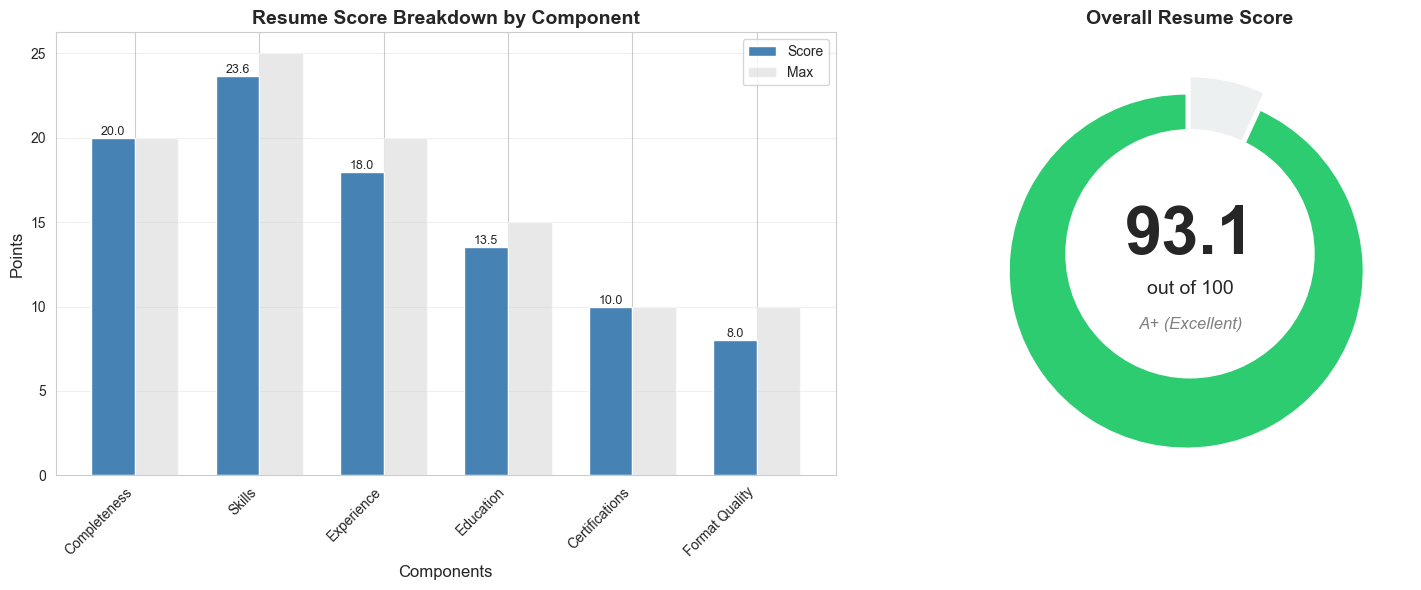

✓ Visualization complete


In [13]:
def visualize_resume_score(score_result: dict):
    """
    Create visualizations for resume score.
    
    Args:
        score_result: Result from calculate_resume_score()
    """
    # Extract component scores
    components = score_result['components']
    comp_names = []
    comp_scores = []
    comp_maxes = []
    
    for name, data in components.items():
        comp_names.append(name.replace('_', ' ').title())
        comp_scores.append(data['score'])
        comp_maxes.append(data['max'])
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Bar chart of component scores
    x = np.arange(len(comp_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, comp_scores, width, label='Score', color='steelblue')
    bars2 = ax1.bar(x + width/2, comp_maxes, width, label='Max', color='lightgray', alpha=0.5)
    
    ax1.set_xlabel('Components', fontsize=12)
    ax1.set_ylabel('Points', fontsize=12)
    ax1.set_title('Resume Score Breakdown by Component', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(comp_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 2. Gauge chart for overall score
    score = score_result['total_score']
    
    # Create a simple gauge using pie chart
    sizes = [score, 100-score]
    colors = ['#2ecc71' if score >= 70 else '#f39c12' if score >= 50 else '#e74c3c', '#ecf0f1']
    explode = (0.1, 0)
    
    wedges, texts = ax2.pie(sizes, colors=colors, startangle=90, explode=explode)
    
    # Add circle in center for donut effect
    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax2.add_artist(center_circle)
    
    # Add score text in center
    ax2.text(0, 0.1, f'{score:.1f}', fontsize=48, ha='center', va='center', fontweight='bold')
    ax2.text(0, -0.2, 'out of 100', fontsize=14, ha='center', va='center')
    ax2.text(0, -0.4, score_result['grade'], fontsize=12, ha='center', va='center', 
             style='italic', color='gray')
    
    ax2.set_title('Overall Resume Score', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# Visualize the test result
visualize_resume_score(result_with_job)

print("✓ Visualization complete")


---


## 11. Test Different Resume Quality Levels


In [14]:
# Test different quality levels
test_resumes = {
    'Excellent Resume': test_resume_full,
    
    'Good Resume': """
    Jane Smith
    jane@email.com | 555-1234
    
    SUMMARY
    Software developer with 4 years experience
    
    EXPERIENCE
    Software Engineer at Tech Startup (2020-Present)
    - Developed Python applications
    - Worked with AWS and Docker
    
    Developer at Small Company (2019-2020)
    
    EDUCATION
    B.S. Computer Science, State University, 2019
    
    SKILLS
    Python, JavaScript, React, SQL, Git
    """,
    
    'Average Resume': """
    Bob Johnson
    bob@email.com
    
    EXPERIENCE
    Developer, 2021-Present
    Working with various technologies
    
    EDUCATION
    Bachelor degree in IT
    
    SKILLS
    Python, Java, SQL
    """,
    
    'Weak Resume': """
    Alice Brown
    
    Experience: worked at a company for 1 year
    
    Education: college degree
    
    Skills: Microsoft Office, Email
    """
}

print("Testing Different Resume Quality Levels")
print("="*80)

scores_comparison = []

for resume_name, resume_text in test_resumes.items():
    result = calculate_resume_score(resume_text)
    scores_comparison.append({
        'Resume Type': resume_name,
        'Total Score': result['total_score'],
        'Grade': result['grade'],
        'Completeness': result['components']['completeness']['score'],
        'Skills': result['components']['skills']['score'],
        'Experience': result['components']['experience']['score'],
        'Education': result['components']['education']['score'],
        'Certs': result['components']['certifications']['score'],
        'Format': result['components']['format_quality']['score']
    })
    
    print(f"\n{resume_name}:")
    print(f"  Total: {result['total_score']:.1f}/100 - {result['grade']}")

print("\n" + "="*80)


Testing Different Resume Quality Levels

Excellent Resume:
  Total: 94.5/100 - A+ (Excellent)

Good Resume:
  Total: 52.8/100 - D (Needs Improvement)

Average Resume:
  Total: 39.8/100 - F (Poor)

Weak Resume:
  Total: 19.0/100 - F (Poor)




Resume Quality Comparison:
     Resume Type  Total Score                 Grade  Completeness  Skills  Experience  Education  Certs  Format
Excellent Resume        94.50        A+ (Excellent)            20   25.00        18.0       13.5     10       8
     Good Resume        52.75 D (Needs Improvement)            17    8.75        11.0        9.0      0       7
  Average Resume        39.75              F (Poor)            15    3.75         7.0        9.0      0       5
     Weak Resume        19.00              F (Poor)            15    0.00         3.0        0.0      0       1


<Figure size 1200x600 with 0 Axes>

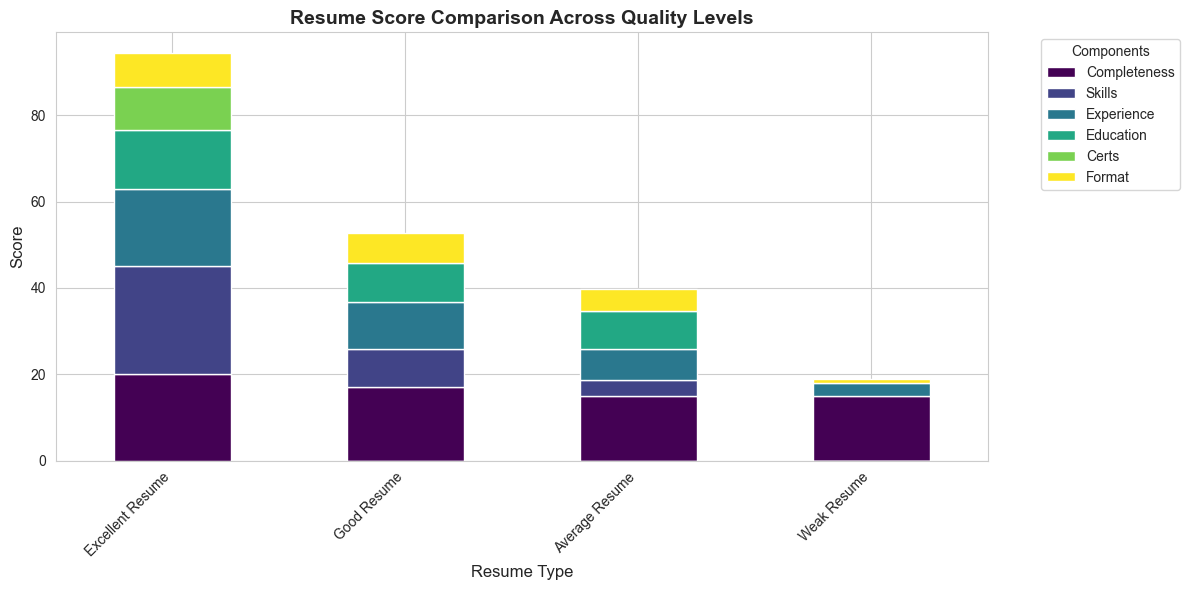


✓ Scoring system successfully differentiates resume quality levels!


In [15]:
# Display comparison table
df_comparison = pd.DataFrame(scores_comparison)

print("\nResume Quality Comparison:")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Visualize comparison
plt.figure(figsize=(12, 6))
df_comparison_plot = df_comparison.set_index('Resume Type')[['Completeness', 'Skills', 'Experience', 'Education', 'Certs', 'Format']]
df_comparison_plot.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Resume Score Comparison Across Quality Levels', fontsize=14, fontweight='bold')
plt.xlabel('Resume Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Components', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✓ Scoring system successfully differentiates resume quality levels!")


---


## 12. Production Code

The following class is ready for extraction into production modules.


In [16]:
# PRODUCTION CODE

import re
from typing import Optional


class ResumeScorer:
    """
    Comprehensive resume scoring system with multiple weighted components.
    """
    
    def __init__(self):
        """Initialize the scorer with skill database."""
        self.all_skills = self._load_skills()
    
    def _load_skills(self) -> list:
        """Load comprehensive skill list."""
        skills = [
            # Programming
            'Python', 'Java', 'JavaScript', 'TypeScript', 'C++', 'C#', 'Go', 'Ruby',
            # Web
            'React', 'Angular', 'Vue.js', 'Django', 'Flask', 'Node.js', 'Spring',
            # Databases
            'SQL', 'MySQL', 'PostgreSQL', 'MongoDB', 'Redis',
            # Cloud & DevOps
            'AWS', 'Azure', 'GCP', 'Docker', 'Kubernetes', 'Terraform', 'Jenkins',
            # ML/AI
            'Machine Learning', 'TensorFlow', 'PyTorch', 'Scikit-learn',
            # Other
            'Git', 'Agile', 'Scrum', 'REST API',
        ]
        return skills
    
    def score(self, resume_text: str, job_description: Optional[str] = None) -> dict:
        """
        Calculate comprehensive resume score.
        
        Args:
            resume_text: Resume text
            job_description: Optional job description for matching
        
        Returns:
            Dictionary with total score and component breakdowns
        """
        # Calculate components
        completeness = self._score_completeness(resume_text)
        skills = self._score_skills(resume_text, job_description)
        experience = self._score_experience(resume_text)
        education = self._score_education(resume_text)
        certifications = self._score_certifications(resume_text)
        format_quality = self._score_format(resume_text)
        
        total = sum([
            completeness['score'],
            skills['score'],
            experience['score'],
            education['score'],
            certifications['score'],
            format_quality['score']
        ])
        
        return {
            'total_score': total,
            'grade': self._get_grade(total),
            'components': {
                'completeness': completeness,
                'skills': skills,
                'experience': experience,
                'education': education,
                'certifications': certifications,
                'format_quality': format_quality
            }
        }
    
    def _score_completeness(self, text: str) -> dict:
        """Score section completeness (20 pts)."""
        sections = ['experience', 'education', 'skills', 'summary']
        found = sum(1 for s in sections if re.search(s, text, re.IGNORECASE))
        score = min(20, found * 5)
        return {'score': score, 'max': 20, 'sections_found': found}
    
    def _score_skills(self, text: str, job_desc: Optional[str]) -> dict:
        """Score skills (25 pts)."""
        resume_skills = [s for s in self.all_skills if re.search(r'\b' + re.escape(s.lower()) + r'\b', text.lower())]
        diversity = min(10, len(resume_skills) * 0.5)
        
        if job_desc:
            job_skills = [s for s in self.all_skills if re.search(r'\b' + re.escape(s.lower()) + r'\b', job_desc.lower())]
            match = len(set(resume_skills) & set(job_skills))
            match_score = (match / len(job_skills) * 15) if job_skills else 0
        else:
            match_score = min(15, len(resume_skills) * 0.75)
        
        return {'score': diversity + match_score, 'max': 25, 'skills_found': len(resume_skills)}
    
    def _score_experience(self, text: str) -> dict:
        """Score experience (20 pts)."""
        years = self._extract_years(text)
        score = min(15, years * 1.5) if years > 0 else 0
        if re.search(r'\b(senior|lead|managed)\b', text, re.IGNORECASE):
            score += 5
        return {'score': min(20, score), 'max': 20, 'years': years}
    
    def _score_education(self, text: str) -> dict:
        """Score education (15 pts)."""
        if re.search(r'\b(phd|ph\.d\.)\b', text, re.IGNORECASE):
            score = 15
        elif re.search(r'\b(master|m\.s\.|mba)\b', text, re.IGNORECASE):
            score = 12
        elif re.search(r'\b(bachelor|b\.s\.)\b', text, re.IGNORECASE):
            score = 9
        else:
            score = 3
        return {'score': score, 'max': 15}
    
    def _score_certifications(self, text: str) -> dict:
        """Score certifications (10 pts)."""
        certs = ['AWS', 'Azure', 'GCP', 'PMP', 'CISSP', 'CSM']
        found = sum(1 for c in certs if re.search(r'\b' + c + r'\b', text, re.IGNORECASE))
        score = min(10, found * 2.5)
        return {'score': score, 'max': 10, 'certs_found': found}
    
    def _score_format(self, text: str) -> dict:
        """Score format quality (10 pts)."""
        score = 0
        if bool(re.search(r'@', text)):
            score += 3
        if 500 <= len(text.split()) <= 2000:
            score += 4
        if len(re.findall(r'^[A-Z\s]{3,}:?\s*$', text, re.MULTILINE)) >= 3:
            score += 3
        return {'score': min(10, score), 'max': 10}
    
    def _extract_years(self, text: str) -> int:
        """Extract years of experience."""
        matches = re.findall(r'(\d+)\+?\s*years?', text, re.IGNORECASE)
        return max([int(m) for m in matches], default=0)
    
    def _get_grade(self, score: float) -> str:
        """Convert score to grade."""
        if score >= 90: return 'A+'
        elif score >= 80: return 'A'
        elif score >= 70: return 'B'
        elif score >= 60: return 'C'
        else: return 'D'


print("✓ Production class defined: ResumeScorer")
print("\nMethods:")
print("  - score(resume_text, job_description=None)")
print("\nThis class is ready to be extracted to models/scorer.py")


✓ Production class defined: ResumeScorer

Methods:
  - score(resume_text, job_description=None)

This class is ready to be extracted to models/scorer.py


In [17]:
# Test production class
scorer = ResumeScorer()
result_prod = scorer.score(test_resume_full, job_description)

print("\nProduction Class Test:")
print("="*60)
print(f"Total Score: {result_prod['total_score']:.1f}/100")
print(f"Grade: {result_prod['grade']}")
print("\n✓ Production class tested successfully")



Production Class Test:
Total Score: 88.3/100
Grade: A

✓ Production class tested successfully


---

## 13. Generate Actionable Recommendations

Based on component scores, generate specific feedback for improvement.


---

## 14. Enhanced Features (Inspired by Resume-Matcher)

Advanced scoring using TF-IDF, cosine similarity, and detailed ATS analysis.


In [18]:
from collections import Counter
from math import sqrt

def calculate_tfidf_similarity(resume_text: str, job_description: str) -> dict:
    """
    Calculate TF-IDF based cosine similarity between resume and job description.
    
    Args:
        resume_text: Resume text
        job_description: Job description text
    
    Returns:
        Dictionary with similarity score and keyword analysis
    """
    # Tokenize and clean
    def tokenize(text):
        words = re.findall(r'\b\w+\b', text.lower())
        return [w for w in words if len(w) > 2]  # Filter short words
    
    resume_words = tokenize(resume_text)
    job_words = tokenize(job_description)
    
    # Calculate word frequencies
    resume_freq = Counter(resume_words)
    job_freq = Counter(job_words)
    
    # Get all unique words
    all_words = set(resume_words + job_words)
    
    # Calculate TF-IDF vectors (simplified - TF only for speed)
    resume_vector = {word: resume_freq.get(word, 0) for word in all_words}
    job_vector = {word: job_freq.get(word, 0) for word in all_words}
    
    # Calculate cosine similarity
    dot_product = sum(resume_vector[w] * job_vector[w] for w in all_words)
    
    resume_magnitude = sqrt(sum(v**2 for v in resume_vector.values()))
    job_magnitude = sqrt(sum(v**2 for v in job_vector.values()))
    
    if resume_magnitude == 0 or job_magnitude == 0:
        similarity = 0
    else:
        similarity = dot_product / (resume_magnitude * job_magnitude)
    
    # Find important keywords (high frequency in job, present in resume)
    important_keywords = []
    for word, count in job_freq.most_common(20):
        if count >= 2 and word in resume_freq:  # Mentioned 2+ times in job
            importance = 'HIGH' if count >= 4 else 'MEDIUM' if count >= 3 else 'LOW'
            important_keywords.append({
                'keyword': word,
                'importance': importance,
                'job_frequency': count,
                'resume_frequency': resume_freq[word]
            })
    
    # Find missing important keywords
    missing_keywords = []
    for word, count in job_freq.most_common(15):
        if count >= 3 and word not in resume_freq:
            importance = 'HIGH' if count >= 5 else 'MEDIUM'
            missing_keywords.append({
                'keyword': word,
                'importance': importance,
                'frequency_in_job': count
            })
    
    return {
        'similarity_score': similarity * 100,  # Convert to percentage
        'matched_keywords': important_keywords,
        'missing_keywords': missing_keywords[:10],  # Top 10
        'resume_word_count': len(resume_words),
        'job_word_count': len(job_words),
        'unique_match_count': len([w for w in resume_words if w in job_words])
    }


# Test TF-IDF similarity
test_resume = """
Senior Software Engineer with 8 years experience in Python development.
Expert in AWS, Docker, Kubernetes, and microservices architecture.
Led teams, increased performance, reduced costs. 
Strong experience with machine learning, TensorFlow, and cloud platforms.
"""

test_job = """
We're seeking a Senior Software Engineer with:
- 5+ years of Python development experience
- Strong AWS and cloud platform experience
- Docker and Kubernetes expertise
- Microservices architecture knowledge
- Machine learning background preferred
- Leadership and team management skills
"""

tfidf_result = calculate_tfidf_similarity(test_resume, test_job)

print("TF-IDF Similarity Analysis")
print("="*60)
print(f"Overall Similarity: {tfidf_result['similarity_score']:.1f}%")
print(f"\nMatched Important Keywords: {len(tfidf_result['matched_keywords'])}")
for kw in tfidf_result['matched_keywords'][:5]:
    print(f"  • {kw['keyword'].upper()} ({kw['importance']}): Job={kw['job_frequency']}x, Resume={kw['resume_frequency']}x")

print(f"\nMissing Keywords: {len(tfidf_result['missing_keywords'])}")
for kw in tfidf_result['missing_keywords'][:5]:
    print(f"  ❌ {kw['keyword'].upper()} ({kw['importance']}): Mentioned {kw['frequency_in_job']}x in job")

print("\n✓ TF-IDF similarity function defined")


TF-IDF Similarity Analysis
Overall Similarity: 72.1%

Matched Important Keywords: 2
  • AND (MEDIUM): Job=3x, Resume=2x
  • EXPERIENCE (LOW): Job=2x, Resume=2x

Missing Keywords: 0

✓ TF-IDF similarity function defined


In [19]:
def analyze_ats_compatibility(text: str) -> dict:
    """
    Detailed ATS (Applicant Tracking System) compatibility analysis.
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with ATS compatibility details
    """
    issues = []
    warnings = []
    score = 100  # Start at 100, deduct points for issues
    
    # Check for problematic formatting
    # 1. Excessive special characters (not ATS-friendly)
    special_chars = len(re.findall(r'[^\w\s.,;:()\-\n]', text))
    if special_chars > len(text) * 0.05:
        issues.append('Too many special characters (tables, graphics, symbols)')
        score -= 15
    
    # 2. Check for potential table indicators
    table_indicators = ['|', '─', '┌', '┐', '└', '┘']
    if any(char in text for char in table_indicators):
        issues.append('Possible table formatting detected (not ATS-friendly)')
        score -= 10
    
    # 3. Check for excessive capitalization
    caps_ratio = sum(1 for c in text if c.isupper()) / max(len(text), 1)
    if caps_ratio > 0.15:
        warnings.append('Excessive capitalization. Use title case for readability')
        score -= 5
    
    # 4. Check for proper section headers
    section_headers = len(re.findall(r'^[A-Z\s]{3,}:?\s*$', text, re.MULTILINE))
    if section_headers < 3:
        issues.append('Weak section headers. Use clear ALL CAPS headers')
        score -= 10
    
    # 5. Check for bullet points
    has_bullets = bool(re.search(r'[•\-*]\s', text))
    if not has_bullets:
        warnings.append('No bullet points found. Use bullets for readability')
        score -= 5
    
    # 6. Check for contact information
    has_email = bool(re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text))
    has_phone = bool(re.search(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', text))
    
    if not has_email:
        issues.append('Missing email address')
        score -= 20
    
    if not has_phone:
        warnings.append('Missing phone number')
        score -= 5
    
    # 7. Check for URLs/links (can cause ATS issues)
    urls = len(re.findall(r'http[s]?://', text))
    if urls > 3:
        warnings.append('Multiple URLs/links may confuse ATS. Use text instead')
        score -= 5
    
    # 8. Word count check
    word_count = len(text.split())
    if word_count < 400:
        issues.append(f'Too short ({word_count} words). Aim for 600-800')
        score -= 15
    elif word_count > 1000:
        warnings.append(f'Too long ({word_count} words). Keep under 900')
        score -= 10
    
    score = max(0, score)  # Don't go below 0
    
    return {
        'ats_score': score,
        'ats_percentage': score,
        'issues': issues,
        'warnings': warnings,
        'is_ats_friendly': score >= 70,
        'recommendations': []
    }


# Test ATS analysis
test_resume_ats = """
JOHN DOE
john.doe@email.com | (555) 123-4567

PROFESSIONAL EXPERIENCE
• Senior Software Engineer, Tech Corp (2020-Present)
• Developed Python applications with AWS
• Led team of 5 engineers

EDUCATION
• M.S. Computer Science, MIT (2018)

SKILLS
• Python, AWS, Docker, React
"""

ats_result = analyze_ats_compatibility(test_resume_ats)

print("\nATS Compatibility Analysis")
print("="*60)
print(f"ATS Score: {ats_result['ats_score']}/100")
print(f"ATS-Friendly: {'✅ YES' if ats_result['is_ats_friendly'] else '❌ NO'}")

if ats_result['issues']:
    print("\nIssues:")
    for issue in ats_result['issues']:
        print(f"  ❌ {issue}")

if ats_result['warnings']:
    print("\nWarnings:")
    for warning in ats_result['warnings']:
        print(f"  ⚠️ {warning}")

print("\n✓ ATS analysis function defined")



ATS Compatibility Analysis
ATS Score: 70/100
ATS-Friendly: ✅ YES

Issues:
  ❌ Possible table formatting detected (not ATS-friendly)
  ❌ Too short (40 words). Aim for 600-800

Warnings:
  ⚠️ Excessive capitalization. Use title case for readability

✓ ATS analysis function defined


In [20]:
def analyze_action_verbs(text: str) -> dict:
    """
    Analyze usage of strong action verbs (important for resume impact).
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with action verb analysis
    """
    # Strong action verbs for resumes
    strong_verbs = [
        # Leadership
        'led', 'managed', 'directed', 'supervised', 'mentored', 'coached', 'trained',
        # Achievement
        'achieved', 'accomplished', 'delivered', 'exceeded', 'improved', 'increased',
        'reduced', 'saved', 'generated', 'earned',
        # Creation
        'created', 'developed', 'designed', 'built', 'established', 'implemented',
        'launched', 'pioneered', 'introduced',
        # Analysis
        'analyzed', 'evaluated', 'assessed', 'researched', 'identified',
        # Collaboration
        'collaborated', 'coordinated', 'facilitated', 'partnered'
    ]
    
    text_lower = text.lower()
    found_verbs = []
    verb_count = 0
    
    for verb in strong_verbs:
        pattern = r'\b' + verb + r'(ed|ing)?\b'
        matches = len(re.findall(pattern, text_lower))
        if matches > 0:
            found_verbs.append(verb)
            verb_count += matches
    
    # Calculate score
    score = min(10, verb_count * 0.5)  # Max 10 points
    
    return {
        'action_verb_count': verb_count,
        'unique_verbs': len(found_verbs),
        'found_verbs': found_verbs[:10],
        'score': score,
        'has_leadership_verbs': any(v in found_verbs for v in ['led', 'managed', 'directed']),
        'has_achievement_verbs': any(v in found_verbs for v in ['achieved', 'improved', 'increased'])
    }


# Test
test_text = """
Led team of 10 engineers. Developed microservices architecture.
Improved performance by 60%. Managed $2M budget. Created CI/CD pipeline.
Collaborated with cross-functional teams. Analyzed user metrics.
"""

verb_result = analyze_action_verbs(test_text)

print("\nAction Verb Analysis")
print("="*60)
print(f"Action Verbs Found: {verb_result['action_verb_count']} ({verb_result['unique_verbs']} unique)")
print(f"Score: {verb_result['score']:.1f}/10")
print(f"Sample Verbs: {verb_result['found_verbs'][:5]}")
print(f"Has Leadership: {verb_result['has_leadership_verbs']}")
print(f"Has Achievement: {verb_result['has_achievement_verbs']}")
print("\n✓ Action verb analysis function defined")



Action Verb Analysis
Action Verbs Found: 7 (7 unique)
Score: 3.5/10
Sample Verbs: ['led', 'managed', 'improved', 'created', 'developed']
Has Leadership: True
Has Achievement: True

✓ Action verb analysis function defined


In [21]:
def calculate_readability_metrics(text: str) -> dict:
    """
    Calculate readability metrics for resume.
    
    Args:
        text: Resume text
    
    Returns:
        Dictionary with readability metrics
    """
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    
    words = text.split()
    word_count = len(words)
    sentence_count = len(sentences)
    
    if sentence_count == 0:
        return {'score': 0, 'avg_sentence_length': 0, 'avg_word_length': 0}
    
    # Average sentence length
    avg_sentence_length = word_count / sentence_count
    
    # Average word length
    total_chars = sum(len(w) for w in words)
    avg_word_length = total_chars / max(word_count, 1)
    
    # Score based on readability
    # Ideal: 15-20 words per sentence, 4-6 chars per word
    score = 10
    
    if avg_sentence_length > 25:
        score -= 3  # Too complex
    elif avg_sentence_length < 10:
        score -= 2  # Too choppy
    
    if avg_word_length > 7:
        score -= 2  # Too complex
    elif avg_word_length < 4:
        score -= 1  # Too simple
    
    return {
        'score': max(0, score),
        'avg_sentence_length': avg_sentence_length,
        'avg_word_length': avg_word_length,
        'total_sentences': sentence_count,
        'is_readable': 12 <= avg_sentence_length <= 22
    }


# Test
test_readable = """
Senior Software Engineer with 8 years of experience. 
Developed cloud-native applications using Python and AWS.
Led team of 10 engineers. Increased system performance by 60%.
"""

readability = calculate_readability_metrics(test_readable)

print("\nReadability Metrics")
print("="*60)
print(f"Avg Sentence Length: {readability['avg_sentence_length']:.1f} words")
print(f"Avg Word Length: {readability['avg_word_length']:.1f} characters")
print(f"Readable: {'✅ YES' if readability['is_readable'] else '⚠️ Could be better'}")
print(f"Score: {readability['score']:.1f}/10")
print("\n✓ Readability metrics function defined")



Readability Metrics
Avg Sentence Length: 6.2 words
Avg Word Length: 6.0 characters
Readable: ⚠️ Could be better
Score: 8.0/10

✓ Readability metrics function defined


In [22]:
def calculate_enhanced_resume_score(resume_text: str, job_description: str = None) -> dict:
    """
    Enhanced scoring with TF-IDF, ATS analysis, and action verbs.
    
    Args:
        resume_text: Resume text
        job_description: Optional job description
    
    Returns:
        Enhanced score result with additional metrics
    """
    # Base scoring (from earlier functions - would import in production)
    # For demo, we'll calculate a simplified version
    
    result = {
        'total_score': 0,
        'grade': '',
        'enhanced_metrics': {}
    }
    
    # Add TF-IDF similarity if job description provided
    if job_description:
        tfidf = calculate_tfidf_similarity(resume_text, job_description)
        result['enhanced_metrics']['tfidf_similarity'] = tfidf
        result['enhanced_metrics']['overall_match_percentage'] = tfidf['similarity_score']
    
    # Add ATS compatibility
    ats = analyze_ats_compatibility(resume_text)
    result['enhanced_metrics']['ats_compatibility'] = ats
    
    # Add action verb analysis
    verbs = analyze_action_verbs(resume_text)
    result['enhanced_metrics']['action_verbs'] = verbs
    
    # Add readability
    readability = calculate_readability_metrics(resume_text)
    result['enhanced_metrics']['readability'] = readability
    
    return result


# Test enhanced scoring
enhanced_result = calculate_enhanced_resume_score(test_resume, test_job)

print("\nEnhanced Resume Analysis")
print("="*80)

if 'overall_match_percentage' in enhanced_result['enhanced_metrics']:
    print(f"\n📊 OVERALL JOB MATCH: {enhanced_result['enhanced_metrics']['overall_match_percentage']:.1f}%")

print(f"\n✅ ATS COMPATIBILITY: {enhanced_result['enhanced_metrics']['ats_compatibility']['ats_score']}/100")
print(f"   ATS-Friendly: {enhanced_result['enhanced_metrics']['ats_compatibility']['is_ats_friendly']}")

print(f"\n📝 ACTION VERBS: {enhanced_result['enhanced_metrics']['action_verbs']['action_verb_count']} total")
print(f"   Score: {enhanced_result['enhanced_metrics']['action_verbs']['score']:.1f}/10")

print(f"\n📖 READABILITY: {enhanced_result['enhanced_metrics']['readability']['avg_sentence_length']:.1f} words/sentence")
print(f"   Readable: {enhanced_result['enhanced_metrics']['readability']['is_readable']}")

print("\n✓ Enhanced scoring function defined")



Enhanced Resume Analysis

📊 OVERALL JOB MATCH: 72.1%

✅ ATS COMPATIBILITY: 45/100
   ATS-Friendly: False

📝 ACTION VERBS: 3 total
   Score: 1.5/10

📖 READABILITY: 8.2 words/sentence
   Readable: False

✓ Enhanced scoring function defined
